Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from collections import defaultdict, deque
from tqdm import tqdm

Combine all the datasets

In [2]:
print("preprocessing")

all_matches = pd.DataFrame()

for year in range (2000, 2025):
    current_file = "../data/atp_matches_" + str(year)+ ".csv"

    year_data = pd.read_csv(current_file)

    all_matches = pd.concat([all_matches, year_data], axis = 0)

print(all_matches.tail())

preprocessing
                            tourney_id                  tourney_name surface  \
3071  2024-M-DC-2024-WG2-PO-URU-MDA-01  Davis Cup WG2 PO: URU vs MDA    Clay   
3072  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   
3073  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   
3074  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   
3075  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   

      draw_size tourney_level  tourney_date  match_num  winner_id  \
3071          4             D      20240203          5     212051   
3072          4             D      20240202          1     122533   
3073          4             D      20240202          2     144748   
3074          4             D      20240202          4     122533   
3075          4             D      20240202          5     202475   

      winner_seed winner_entry                winner_name winner_hand  \
3071          NaN

Looking good but there's heaps of NaN values - empty values - so we will remove the rows with bad NaN values

In [3]:
print(all_matches.tail())
all_matches_filtered = all_matches.dropna(subset=[    
    "winner_id","loser_id","winner_ht","loser_ht","winner_age","loser_age",
    "w_ace","w_df","w_svpt","w_1stIn","w_1stWon","w_2ndWon","w_SvGms","w_bpSaved","w_bpFaced",
    "l_ace","l_df","l_svpt","l_1stIn","l_1stWon","l_2ndWon","l_SvGms","l_bpSaved","l_bpFaced",
    "winner_rank_points","loser_rank_points","winner_rank","loser_rank","surface"    
]) 

all_matches_filtered = all_matches_filtered.reset_index(drop=True)

print(all_matches_filtered.tail())


                            tourney_id                  tourney_name surface  \
3071  2024-M-DC-2024-WG2-PO-URU-MDA-01  Davis Cup WG2 PO: URU vs MDA    Clay   
3072  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   
3073  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   
3074  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   
3075  2024-M-DC-2024-WG2-PO-VIE-RSA-01  Davis Cup WG2 PO: VIE vs RSA    Hard   

      draw_size tourney_level  tourney_date  match_num  winner_id  \
3071          4             D      20240203          5     212051   
3072          4             D      20240202          1     122533   
3073          4             D      20240202          2     144748   
3074          4             D      20240202          4     122533   
3075          4             D      20240202          5     202475   

      winner_seed winner_entry                winner_name winner_hand  \
3071          NaN          NaN 

There's still heaps of data available to use even after removing these rows

We make a new dataframe with new features to be used for analysis

In [4]:
final_data = pd.DataFrame()
final_data["Winner_ID"] = all_matches_filtered["winner_id"]
final_data["LOSER_ID"] = all_matches_filtered["loser_id"]
final_data["ATP_POINT_DIff"] = all_matches_filtered["winner_rank_points"] - all_matches_filtered["loser_rank_points"]
final_data["ATP_RANK_DIff"] = all_matches_filtered["winner_rank"] - all_matches_filtered["loser_rank"]
final_data["AGE_DIFF"] = all_matches_filtered["winner_age"] - all_matches_filtered["loser_age"]
final_data["HEIGHT_DIFF"] = all_matches_filtered["winner_ht"] - all_matches_filtered["loser_ht"]
final_data["BEST_OF"] = all_matches_filtered["best_of"]
final_data["DRAW_SIZE"] = all_matches_filtered["draw_size"]

We create overall pre-match H2H between players and on specifics surfaces, then create new features being the difference in H2H

In [5]:
#Use defaultdict as when 2 players have never played before, the h2h is 0
#Dictionary is also good to use because we will be gradually adding entries
#Then we can get the H2H of players in O(1) time
h2h_surface_dict = defaultdict(lambda: defaultdict(int))
h2h_dict = defaultdict(int)
total_h2h_surface = []
total_h2h = []

for idx, (winner_id, loser_id, surface) in enumerate(
    tqdm(zip(all_matches_filtered['winner_id'], 
             all_matches_filtered['loser_id'], 
             all_matches_filtered['surface']), 
             total = len(all_matches_filtered))):

    wins = h2h_dict[(winner_id, loser_id)]
    loses = h2h_dict[(loser_id, winner_id)]
    wins_surface = h2h_surface_dict[surface][(winner_id, loser_id)]
    loses_surface = h2h_surface_dict[surface][(loser_id, winner_id)]

    total_h2h.append(wins-loses)
    total_h2h_surface.append(wins_surface-loses_surface)

    h2h_dict[(winner_id, loser_id)] += 1
    h2h_surface_dict[surface][(winner_id, loser_id)] += 1

final_data["H2H_DIFF"] = total_h2h
final_data["H2H_DIFF_SURFACE"] = total_h2h_surface

#Check to see if the H2H tally worked
print(final_data["H2H_DIFF"].unique())

100%|██████████| 67424/67424 [00:00<00:00, 805264.33it/s]

[  0  -1   1  -2   2   3  -3  -4   4   5  -6  -5   6   7   8  -9  -7   9
  10  11  12  13 -10 -14  -8  14  15  16 -11 -12 -13  17  18 -19 -16 -15
  19  20 -21]


Implment Tennis ELO

In [6]:
elo_players = defaultdict(int)
all_elo = defaultdict(lambda: deque())
df_elo_diff = []

for winner_id, loser_id in tqdm(zip(
    all_matches_filtered['winner_id'], 
    all_matches_filtered['loser_id']),
    total = len(all_matches_filtered)):

    #K-factor which affects how sensitive the ELO system is
    k = 32

    elo_winner = elo_players.get(winner_id, 1400)
    elo_loser = elo_players.get(loser_id, 1400)

    E_A = 1 / (1 + 10 ** ((elo_loser - elo_winner) / 400))
    E_B = 1 / (1 + 10 ** ((elo_winner - elo_loser) / 400))

    elo_winner += k * (1 - E_A)
    elo_loser += k * (0 - E_B)

    elo_players[winner_id] = elo_winner
    elo_players[loser_id] = elo_loser

    df_elo_diff.append(elo_winner-elo_loser)
    all_elo[winner_id].append(elo_winner)
    all_elo[loser_id].append(elo_loser)

final_data['ELO_DIFF'] = df_elo_diff

100%|██████████| 67424/67424 [00:00<00:00, 1090027.57it/s]


Implement Elo per surface

In [7]:
elo_surfaces = defaultdict(lambda: defaultdict(int))
all_elo_surfaces = defaultdict(lambda: defaultdict(lambda: deque()))
df_elo_surfaces = []

for winner_id, loser_id, surface in tqdm(zip(
    all_matches_filtered['winner_id'], 
    all_matches_filtered['loser_id'],
    all_matches_filtered['surface']),
    total = len(all_matches_filtered)):

    k = 32

    # Get current ELO ratings (BEFORE this match)
    elo_winner = elo_surfaces[surface].get(winner_id, 1400)
    elo_loser = elo_surfaces[surface].get(loser_id, 1400)

    elo_diff = elo_winner - elo_loser
    df_elo_surfaces.append(elo_diff)


    E_A = 1 / (1 + 10 ** ((elo_loser - elo_winner) / 400))
    E_B = 1 / (1 + 10 ** ((elo_winner - elo_loser) / 400))

    elo_winner += k * (1 - E_A)
    elo_loser += k * (0 - E_B)

    elo_surfaces[surface][winner_id] = elo_winner
    elo_surfaces[surface][loser_id] = elo_loser

    all_elo_surfaces[surface][winner_id].append(elo_winner)
    all_elo_surfaces[surface][loser_id].append(elo_loser)

#append previous rankings on other surfaces so we can draw a continuous curve
    for s in ["Clay", "Grass", "Hard", "Carpet"]:
        if surface != s:
            all_elo_surfaces[s][winner_id].append(elo_surfaces[s].get(winner_id, 1400))
            all_elo_surfaces[s][loser_id].append(elo_surfaces[s].get(loser_id, 1400))
final_data["ELO_SURFACE_DIFF"] = df_elo_surfaces

100%|██████████| 67424/67424 [00:00<00:00, 495422.81it/s]


In [8]:
def plot_player_elo_graph(player_id, player_name):
    plt.close('all')

    player = list(all_elo[player_id])
    player_grass = list(all_elo_surfaces["Grass"][player_id])
    player_clay = list(all_elo_surfaces["Clay"][player_id])
    player_hard = list(all_elo_surfaces["Hard"][player_id])

    # Create a simple line plot
    fig = plt.figure(figsize=(8, 4))

    plt.plot(player_grass, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='green', label="Grass")
    plt.plot(player_clay, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='brown', label="Clay")
    plt.plot(player_hard, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='#ADD8E6', label="Hard")
    plt.plot(player, marker='.', linewidth=0.5, markersize=1, linestyle='-', color='black', label="Overall")


    plt.title(player_name+"'s Elo Rating Over Time")
    plt.xlabel("Match Number")
    plt.ylabel("Elo Rating")

    plt.legend(loc="lower right")

    plt.grid(True)
    import os

    os.makedirs("./images", exist_ok=True)
    plt.savefig("./images/"+"".join(player_name.split())+"_elo_rating.png", dpi=500)

    plt.draw()
    plt.show()

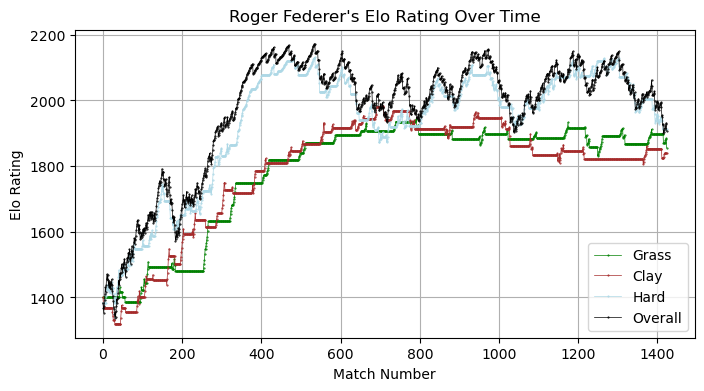

In [9]:
plot_player_elo_graph(103819, "Roger Federer")

In [10]:
import os

# Get the folder where the notebook is running
current_folder = os.getcwd()

# Build full path to data folder
data_folder = os.path.join(current_folder, "../data")
os.makedirs(data_folder, exist_ok=True)

# Save the CSV
final_data.to_csv(os.path.join(data_folder, "1finalDataset.csv"), index=False)
print("✅ Final dataset saved successfully!")

✅ Final dataset saved successfully!


In [11]:
# ============================================
# 8. OPTIMIZED Model Training (Full Dataset)
# ============================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("\n🧠 Training Models with FULL Dataset...")

# OPTIMIZATION: Use vectorized operations for full dataset
print("Creating training data (vectorized)...")

# Create winner perspectives (already in final_data)
X_winner = final_data[[
    "ATP_POINT_DIff", "ATP_RANK_DIff", "AGE_DIFF", "HEIGHT_DIFF", 
    "BEST_OF", "DRAW_SIZE", "H2H_DIFF", "H2H_DIFF_SURFACE", 
    "ELO_DIFF", "ELO_SURFACE_DIFF"
]].values
y_winner = np.ones(len(X_winner))

# Create loser perspectives by flipping features (vectorized)
X_loser = X_winner.copy()
flip_cols = [0, 1, 2, 3, 6, 7, 8, 9]  # Indices of features to flip
X_loser[:, flip_cols] = -X_loser[:, flip_cols]
y_loser = np.zeros(len(X_loser))

# Combine (vectorized)
X_full = np.vstack([X_winner, X_loser])
y_full = np.hstack([y_winner, y_loser])

print(f"Full dataset shape: {X_full.shape}")
print(f"Class distribution: {np.unique(y_full, return_counts=True)}")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train models with full dataset
print("\nTraining SVM with full dataset (this may take a few minutes)...")
svm_model = SVC(kernel='linear', probability=True, random_state=42, C=1.0)
svm_model.fit(X_train_scaled, y_train)
print("✓ SVM training completed")

print("Training MLP with full dataset...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(32, 16), 
    activation='relu', 
    solver='adam',
    max_iter=100, 
    random_state=42, 
    early_stopping=True
)
mlp_model.fit(X_train_scaled, y_train)
print("✓ MLP training completed")

# Evaluate models
print("\nEvaluating models...")
svm_val_preds = svm_model.predict(X_val_scaled)
mlp_val_preds = mlp_model.predict(X_val_scaled)

svm_val_acc = accuracy_score(y_val, svm_val_preds)
mlp_val_acc = accuracy_score(y_val, mlp_val_preds)

svm_probs = svm_model.predict_proba(X_val_scaled)[:, 1]
mlp_probs = mlp_model.predict_proba(X_val_scaled)[:, 1]

svm_auc = roc_auc_score(y_val, svm_probs)
mlp_auc = roc_auc_score(y_val, mlp_probs)

print(f"\n🎯 Validation Results:")
print(f"SVM Accuracy: {svm_val_acc:.4f}, AUC: {svm_auc:.4f}")
print(f"MLP Accuracy: {mlp_val_acc:.4f}, AUC: {mlp_auc:.4f}")

print(f"\n📊 SVM Confusion Matrix:")
print(confusion_matrix(y_val, svm_val_preds))

print(f"📊 MLP Confusion Matrix:")
print(confusion_matrix(y_val, mlp_val_preds))

print(f"\n📈 Probability Ranges:")
print(f"SVM: {svm_probs.min():.3f} to {svm_probs.max():.3f}")
print(f"MLP: {mlp_probs.min():.3f} to {mlp_probs.max():.3f}")


🧠 Training Models with FULL Dataset...
Creating training data (vectorized)...
Full dataset shape: (134848, 10)
Class distribution: (array([0., 1.]), array([67424, 67424]))
Training set: (107878, 10)
Validation set: (26970, 10)

Training SVM with full dataset (this may take a few minutes)...
✓ SVM training completed
Training MLP with full dataset...
✓ MLP training completed

Evaluating models...

🎯 Validation Results:
SVM Accuracy: 0.7601, AUC: 0.8312
MLP Accuracy: 0.7741, AUC: 0.8536

📊 SVM Confusion Matrix:
[[10197  3288]
 [ 3183 10302]]
📊 MLP Confusion Matrix:
[[10510  2975]
 [ 3117 10368]]

📈 Probability Ranges:
SVM: 0.000 to 1.000
MLP: 0.000 to 1.000
